In [21]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/transformer-img/model.py
/kaggle/input/transformer-img/model_blocks.py
/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1947_bacteria_4876.jpeg
/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4875.jpeg
/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1952_bacteria_4883.jpeg
/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1954_bacteria_4886.jpeg
/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1951_bacteria_4882.jpeg
/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1946_bacteria_4874.jpeg
/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person1949_bacteria_4880.jpeg
/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/chest_xray/val/PNEUMONIA/person195

In [22]:
!pip install -U albumentations

In [23]:
!rm /kaggle/working/model_blocks.py
!rm /kaggle/working/model.py

In [24]:
!cp /kaggle/input/transformer-img/model.py /kaggle/working/
!cp /kaggle/input/transformer-img/model_blocks.py /kaggle/working/

In [39]:
import os
import sys
import random
import numpy as np
import pandas as pd
import pathlib
import matplotlib.pyplot as plt
import seaborn as sns
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from typing import Type

In [40]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 0.001
WEIGHT_DECAY = 0.0001
BATCH_SIZE = 32
NUM_EPOCHS = 50
IMAGE_SIZE = 224
PATCH_SIZE = 6
NUM_PATCHES = (IMAGE_SIZE // PATCH_SIZE) ** 2
PROJECTION_DIM = 64
NUM_HEADS = 4
TRANSFORMER_LAYERS = 8
MLP_HEAD_UNITS = [2048, 1024]

In [41]:
class CreatePatchesLayer(torch.nn.Module):
    def __init__(
        self,
        patch_size: int,
        strides: int,
    ) -> None:
        super().__init__()
        self.unfold_layer = torch.nn.Unfold(
            kernel_size=patch_size, stride=strides
        )

    def forward(self, images: torch.Tensor) -> torch.Tensor:
        patched_images = self.unfold_layer(images)
        return patched_images.permute((0, 2, 1))


class PatchEmbeddingLayer(torch.nn.Module):
    def __init__(
        self,
        num_patches: int,
        batch_size: int,
        patch_size: int,
        embed_dim: int,
        device: torch.device,
    ) -> None:
        super().__init__()
        self.num_patches = num_patches
        self.patch_size = patch_size
        self.position_emb = torch.nn.Embedding(
            num_embeddings=num_patches + 1, embedding_dim=embed_dim
        )
        self.projection_layer = torch.nn.Linear(
            patch_size * patch_size * 3, embed_dim
        )
        self.class_parameter = torch.nn.Parameter(
            torch.rand(batch_size, 1, embed_dim).to(device),
            requires_grad=True,
        )
        self.device = device

    def forward(self, patches: torch.Tensor) -> torch.Tensor:
        positions = (
            torch.arange(start=0, end=self.num_patches + 1, step=1)
            .to(self.device)
            .unsqueeze(dim=0)
        )
        patches = self.projection_layer(patches)
        encoded_patches = torch.cat(
            (self.class_parameter, patches), dim=1
        ) + self.position_emb(positions)
        return encoded_patches


def create_mlp_block(
    input_features: int,
    output_features: list[int],
    activation_function: Type[torch.nn.Module],
    dropout_rate: float,
) -> torch.nn.Module:
    layer_list = []
    for idx in range(
        len(output_features)
    ):
        if idx == 0:
            linear_layer = torch.nn.Linear(
                in_features=input_features, out_features=output_features[idx]
            )
        else:
            linear_layer = torch.nn.Linear(
                in_features=output_features[idx - 1],
                out_features=output_features[idx],
            )
        dropout = torch.nn.Dropout(p=dropout_rate)
        layers = torch.nn.Sequential(
            linear_layer, activation_function(), dropout
        )
        layer_list.append(layers)
    return torch.nn.Sequential(*layer_list)


class TransformerBlock(torch.nn.Module):
    def __init__(
        self,
        num_heads: int,
        key_dim: int,
        embed_dim: int,
        ff_dim: int,
        dropout_rate: float = 0.1,
    ) -> None:
        super().__init__()
        self.layer_norm_input = torch.nn.LayerNorm(
            normalized_shape=embed_dim, eps=1e-6
        )
        self.attn = torch.nn.MultiheadAttention(
            embed_dim=embed_dim,
            num_heads=num_heads,
            kdim=key_dim,
            vdim=key_dim,
            batch_first=True,
        )

        self.dropout_1 = torch.nn.Dropout(p=dropout_rate)
        self.layer_norm_1 = torch.nn.LayerNorm(
            normalized_shape=embed_dim, eps=1e-6
        )
        self.layer_norm_2 = torch.nn.LayerNorm(
            normalized_shape=embed_dim, eps=1e-6
        )
        self.ffn = create_mlp_block(
            input_features=embed_dim,
            output_features=[ff_dim, embed_dim],
            activation_function=torch.nn.GELU,
            dropout_rate=dropout_rate,
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        layer_norm_inputs = self.layer_norm_input(inputs)
        attention_output, _ = self.attn(
            query=layer_norm_inputs,
            key=layer_norm_inputs,
            value=layer_norm_inputs,
        )
        attention_output = self.dropout_1(attention_output)
        out1 = self.layer_norm_1(inputs + attention_output)
        ffn_output = self.ffn(out1)
        output = self.layer_norm_2(out1 + ffn_output)
        return output

In [42]:
class ViTClassifier(torch.nn.Module):
    def __init__(
        self,
        num_transformer_layers: int,
        embed_dim: int,
        feed_forward_dim: int,
        num_heads: int,
        patch_size: int,
        num_patches: int,
        mlp_head_units: list[int],
        num_classes: int,
        batch_size: int,
        device: torch.device,
    ) -> None:
        super().__init__()
        self.create_patch_layer = CreatePatchesLayer(patch_size, patch_size)
        self.patch_embedding_layer = PatchEmbeddingLayer(
            num_patches, batch_size, patch_size, embed_dim, device
        )
        self.transformer_layers = torch.nn.ModuleList()
        for _ in range(num_transformer_layers):
            self.transformer_layers.append(
                TransformerBlock(
                    num_heads, embed_dim, embed_dim, feed_forward_dim
                )
            )

        self.mlp_block = create_mlp_block(
            input_features=embed_dim,
            output_features=mlp_head_units,
            activation_function=torch.nn.GELU,
            dropout_rate=0.5,
        )

        self.logits_layer = torch.nn.Linear(mlp_head_units[-1], num_classes)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.create_patch_layer(x)
        x = self.patch_embedding_layer(x)
        for transformer_layer in self.transformer_layers:
            x = transformer_layer(x)
        x = x[:, 0]
        x = self.mlp_block(x)
        x = self.logits_layer(x)
        return x

In [43]:
base_dir = '/kaggle/input/transformer-img/chest-xray-pneumonia/chest_xray/'

train_pneumonia_dir = base_dir+'train/PNEUMONIA/'
train_normal_dir=base_dir+'train/NORMAL/'

test_pneumonia_dir = base_dir+'test/PNEUMONIA/'
test_normal_dir = base_dir+'test/NORMAL/'

val_normal_dir= base_dir+'val/NORMAL/'
val_pnrumonia_dir= base_dir+'val/PNEUMONIA/'

train_pn = [train_pneumonia_dir+"{}".format(i) for i in os.listdir(train_pneumonia_dir) ]
train_normal = [train_normal_dir+"{}".format(i) for i in os.listdir(train_normal_dir) ]

test_normal = [test_normal_dir+"{}".format(i) for i in os.listdir(test_normal_dir)]
test_pn = [test_pneumonia_dir+"{}".format(i) for i in os.listdir(test_pneumonia_dir)]

val_pn= [val_pnrumonia_dir+"{}".format(i) for i in os.listdir(val_pnrumonia_dir) ]
val_normal= [val_normal_dir+"{}".format(i) for i in os.listdir(val_normal_dir) ]

print ("Total images:",len(train_pn+train_normal+test_normal+test_pn+val_pn+val_normal))
print ("Total pneumonia images:",len(train_pn+test_pn+val_pn))
print ("Total Nomral images:",len(train_normal+test_normal+val_normal))

Total images: 5856
Total pneumonia images: 4273
Total Nomral images: 1583


In [44]:
pn = train_pn + test_pn + val_pn
normal = train_normal + test_normal + val_normal

train_imgs = pn[:3418]+ normal[:1224]
test_imgs = pn[3418:4059]+ normal[1224:1502]
val_imgs = pn[4059:] + normal[1502:]

print("Total Train Images %s containing %s pneumonia and %s normal images" 
      % (len(train_imgs),len(pn[:3418]),len(normal[:1224])))
print("Total Test Images %s containing %s pneumonia and %s normal images"
      % (len(test_imgs),len(pn[3418:4059]),len(normal[1224:1502])))
print("Total validation Images %s containing %s pneumonia and %s normal images" 
      % (len(val_imgs),len(pn[4059:]),len(normal[1502:])))

random.shuffle(train_imgs)
random.shuffle(test_imgs)
random.shuffle(val_imgs)

Total Train Images 4642 containing 3418 pneumonia and 1224 normal images
Total Test Images 919 containing 641 pneumonia and 278 normal images
Total validation Images 295 containing 214 pneumonia and 81 normal images


/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


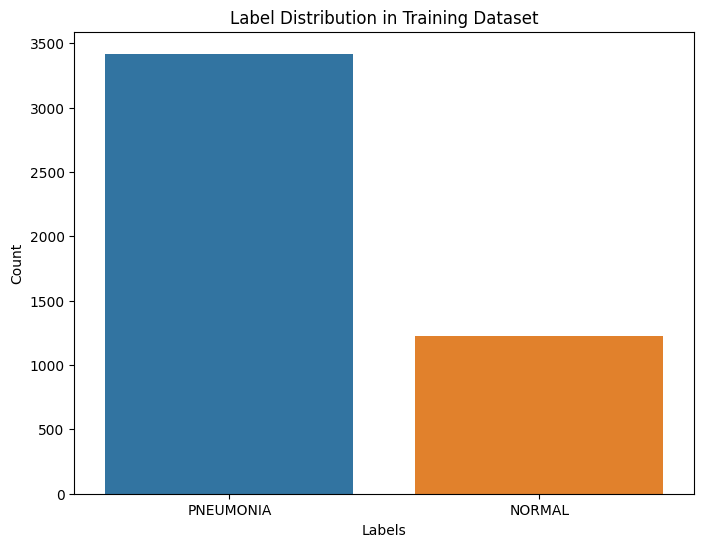

PNEUMONIA    3418
NORMAL       1224
Name: count, dtype: int64

In [45]:
train_labels = ['PNEUMONIA' if 'PNEUMONIA' in img else 'NORMAL' for img in train_imgs]
label_counts = pd.Series(train_labels).value_counts()

plt.figure(figsize=(8, 6))
sns.countplot(x=train_labels)
plt.title('Label Distribution in Training Dataset')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.show()

label_counts

In [46]:
class ChestXRayDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.labels = [1 if 'PNEUMONIA' in path else 0 for path in image_paths]
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]

        image = Image.open(img_path).convert("RGB")
        image = np.array(image)

        if self.transform:
            augmented = self.transform(image=image)
            image = augmented["image"]

        return image, label

In [47]:
train_transform = A.Compose([
    A.Resize(224, 224),
    A.HorizontalFlip(p=0.5),
    A.RandomRotate90(p=0.5),
    A.Affine(scale=(0.95, 1.05), p=0.5),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.CLAHE(p=0.3),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

test_val_transform = A.Compose([
    A.Resize(224, 224),
    A.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5)),
    ToTensorV2(),
])

In [48]:
train_dataset = ChestXRayDataset(train_imgs, transform=train_transform)
test_dataset = ChestXRayDataset(test_imgs, transform=test_val_transform)
val_dataset = ChestXRayDataset(val_imgs, transform=test_val_transform)

In [49]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, pin_memory=True, num_workers=2, drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, pin_memory=True, num_workers=2, drop_last=True)

In [50]:
model = ViTClassifier(
    num_transformer_layers=TRANSFORMER_LAYERS,
    embed_dim=PROJECTION_DIM,
    feed_forward_dim=PROJECTION_DIM * 2,
    num_heads=NUM_HEADS,
    patch_size=PATCH_SIZE,
    num_patches=NUM_PATCHES,
    mlp_head_units=MLP_HEAD_UNITS,
    num_classes=2,
    batch_size=BATCH_SIZE,
    device=DEVICE,
).to(DEVICE)

In [51]:
optimizer = torch.optim.AdamW(
    params=filter(lambda param: param.requires_grad, model.parameters()),
    lr=LEARNING_RATE,
    weight_decay=WEIGHT_DECAY,
)
loss_function = torch.nn.CrossEntropyLoss()

In [52]:
def calculate_accuracy(outputs, ground_truth):
    softmaxed_output = torch.nn.functional.softmax(outputs, dim=1)
    predictions = torch.argmax(softmaxed_output, dim=1)
    num_correct = int(torch.sum(torch.eq(predictions, ground_truth)).item())
    return num_correct, ground_truth.size()[0]

In [53]:
def train(
    model,
    num_epochs,
    optimizer,
    loss_function,
    trainloader,
    validloader,
    device,
    output_file="training_run.out",
):
    with open(output_file, "w") as f:
        f.write("Training Started\n")
        for epoch in range(1, num_epochs + 1):
            train_loss = []
            valid_loss = []
            num_examples_train = 0
            num_correct_train = 0
            num_examples_valid = 0
            num_correct_valid = 0
            
            model.train()
            for batch in trainloader:
                optimizer.zero_grad()
                x = batch[0].to(device)
                y = batch[1].to(device)
                outputs = model(x)
                loss = loss_function(outputs, y)
                loss.backward()
                optimizer.step()
                train_loss.append(loss.item())
                num_corr, num_ex = calculate_accuracy(outputs, y)
                num_examples_train += num_ex
                num_correct_train += num_corr

            model.eval()
            with torch.no_grad():
                for batch in validloader:
                    images = batch[0].to(device)
                    labels = batch[1].to(device)
                    outputs = model(images)
                    loss = loss_function(outputs, labels)
                    valid_loss.append(loss.item())
                    num_corr, num_ex = calculate_accuracy(outputs, labels)
                    num_examples_valid += num_ex
                    num_correct_valid += num_corr

            log_line = (
                f"Epoch: {epoch}, Training Loss: {np.mean(train_loss):.4f}, "
                f"Validation Loss: {np.mean(valid_loss):.4f}, Training Accuracy: {num_correct_train/num_examples_train:.4f}, "
                f"Validation Accuracy: {num_correct_valid/num_examples_valid:.4f}\n"
            )
            print(log_line.strip())
            f.write(log_line)

In [54]:
train(
    model=model,
    num_epochs=NUM_EPOCHS,
    optimizer=optimizer,
    loss_function=loss_function,
    trainloader=train_loader,
    validloader=val_loader,
    device=DEVICE,
)

Epoch: 1, Training Loss: 0.5998, Validation Loss: 0.5796, Training Accuracy: 0.7328, Validation Accuracy: 0.7326
Epoch: 2, Training Loss: 0.5796, Validation Loss: 0.5765, Training Accuracy: 0.7351, Validation Accuracy: 0.7326
Epoch: 3, Training Loss: 0.5363, Validation Loss: 0.5675, Training Accuracy: 0.7457, Validation Accuracy: 0.7326
Epoch: 4, Training Loss: 0.4458, Validation Loss: 0.8851, Training Accuracy: 0.7976, Validation Accuracy: 0.7569
Epoch: 5, Training Loss: 0.4048, Validation Loss: 0.4384, Training Accuracy: 0.8213, Validation Accuracy: 0.8090
Epoch: 6, Training Loss: 0.3651, Validation Loss: 0.7024, Training Accuracy: 0.8362, Validation Accuracy: 0.7465
Epoch: 7, Training Loss: 0.2984, Validation Loss: 0.9090, Training Accuracy: 0.8864, Validation Accuracy: 0.7778
Epoch: 8, Training Loss: 0.2878, Validation Loss: 0.5625, Training Accuracy: 0.8789, Validation Accuracy: 0.8021
Epoch: 9, Training Loss: 0.2738, Validation Loss: 0.4533, Training Accuracy: 0.8873, Validation 

In [55]:
def test(
    model,
    loss_function,
    testloader,
    device,
):
    test_loss = []
    num_examples = 0
    num_correct = 0
    model.eval()
    with torch.no_grad():
        for batch in testloader:
            images = batch[0].to(device)
            labels = batch[1].to(device)
            output = model(images)
            loss = loss_function(output, labels)
            test_loss.append(loss.item())
            num_corr, num_ex = calculate_accuracy(output, labels)
            num_examples += num_ex
            num_correct += num_corr
        print(
            f"Test Loss: {np.mean(test_loss):.4f}, Test Accuracy: {num_correct/num_examples:.4f}"
        )

In [56]:
test(
    model=model,
    loss_function=loss_function,
    testloader=test_loader,
    device=DEVICE,
)

Test Loss: 1.1781, Test Accuracy: 0.8292


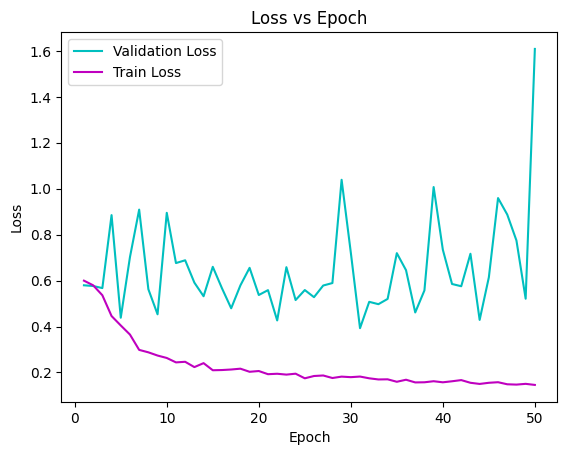

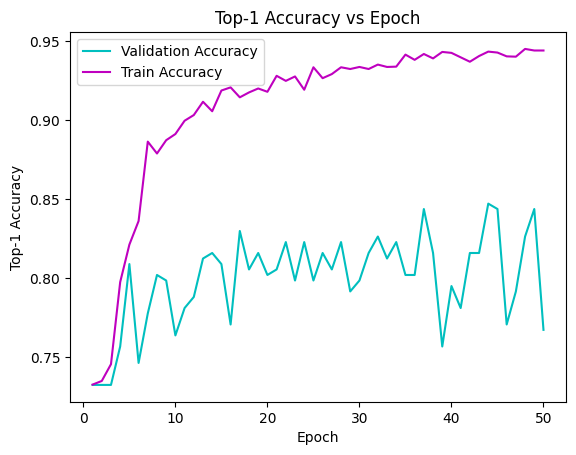

<Figure size 640x480 with 0 Axes>

In [58]:
import matplotlib.pyplot as plt

training_stats = open('training_run.out', 'r', encoding="UTF-8")
train_loss = []
valid_loss = []
train_accuracy = []
valid_accuracy = []
train_accuracy_5 = []
valid_accuracy_5 = []

for i in training_stats:
    if 'Validation Accuracy' in i:
        try:
            y = i.split()
            train_loss.append(float(y[4].strip(',')))
            valid_loss.append(float(y[7].strip(',')))
            train_accuracy.append(float(y[10].strip(',')))
            valid_accuracy.append(float(y[13].strip(',')))
            train_accuracy_5.append(float(y[17].strip(',')))
            valid_accuracy_5.append(float(y[21].strip(',')))
        except IndexError:
            continue

epochs = [i for i in range(1, len(train_loss) + 1)]

plt.plot(epochs, valid_loss, '-c', label='Validation Loss')
plt.plot(epochs, train_loss, '-m', label='Train Loss')
plt.title('Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Loss.png')
plt.show()
plt.clf()

plt.plot(epochs, valid_accuracy, '-c', label='Validation Accuracy')
plt.plot(epochs, train_accuracy, '-m', label='Train Accuracy')
plt.title('Top-1 Accuracy vs Epoch')
plt.ylabel('Top-1 Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.savefig('Top-1 Accuracy.png')
plt.show()
plt.clf()
